<a href="https://colab.research.google.com/github/chanwoo522/Hackathon/blob/main/%5BTPU%5DCNN_Classification_v0_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [2]:
!pip install torch
!pip install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import re
import shutil

from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional

In [3]:
# 환경설정 할 때만 실행
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

     |████████████████████████████████| 149.9 MB 76 kB/s 
     |████████████████████████████████| 57 kB 2.4 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.277 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  34106      0 --:--:-- --:--:-- --:--:-- 34106
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Found existing ins

In [4]:
import torch_xla
import torch_xla.core.xla_model as xm

In [5]:
DEVICE = xm.xla_device()

## 구글 드라이브 마운트

In [6]:
# load image files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모델링

In [7]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 7,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

## 작업 폴더 설정

In [8]:
## directory 설정
image_files = []
Labels=[]
class_name=[]

cur_dir = os.path.abspath('/content/drive/Shareddrives/aircraft')
image_dir = os.path.join(cur_dir, 'edge')
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.png']

# labeling
print(Labels)
Labels = set()

for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\w*\W*\w*\w*\W*\w*', '', file_name)
    Labels.add(class_name)
Labels = list(Labels)

print(Labels)

# Experiment directory setting

train_dir = os.path.join(cur_dir, 'train_dir')
test_dir = os.path.join(cur_dir, 'test_dir')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in Labels:
  label_dir = os.path.join(train_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  label_dir = os.path.join(test_dir, label)
  os.makedirs(label_dir, exist_ok=True)

[]
['F-22', 'F-16', 'B-1', 'KC-330', 'E-737', 'F-4', 'C-130', 'F-18', 'F-5', 'FA-50', 'B-2', 'F-15', 'A-10', 'F-35']


## 이미지 파일 train, test data로 분리

In [ ]:
# practice file separate
cnt = 0
previous_class = ""
image_files.sort()

for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\w*\W*\w*\w*\W*\w*', '', file_name)
  if class_name == previous_class:
    cnt += 1
  else:
    cnt = 1
  if cnt >= 800 and cnt % 4 == 0:
    for label in Labels:
        if label == class_name:
          cpath = os.path.join(test_dir, label)
          cfile = os.path.join(cpath, image_file)
          image_path = os.path.join(image_dir, image_file)
          if cfile == image_path:
            pass
          else:
            shutil.copy(image_path, cpath)
        else:
          pass
  else:
    for label in Labels:
        if label == class_name:
          cpath = os.path.join(train_dir, label)
          cfile = os.path.join(cpath, image_file)
          image_path = os.path.join(image_dir, image_file)
          if cfile == image_path:
            pass
          else:
            shutil.copy(image_path, cpath)
        else:
          pass
  previous_class = class_name

KeyboardInterrupt: ignored

## 불필요 메모리 삭제

In [9]:
import gc
image_files = []
Labels=[]
class_name=[]
gc.collect()
torch.cuda.empty_cache()

## 하이퍼파라미터 세팅

In [10]:
# Hyperparameter
## Dataload
EPOCHS = 70       # 40, 150, 300
BATCH_SIZE = 8   # 16, 64, 128
img_size = 256

## Optimizer
lr=0.01
betas=(0.9, 0.999)

## Scheduler
step_size=10
gamma=0.5

## 데이터 정규화 및 로드

train_dataset length : 11130
test_dataset length : 700
train RGB Channel size, W, H : torch.Size([1, 256, 256])
test RGB Channel size, W, H : torch.Size([1, 256, 256])
train_loader length : 1392
test_loader length : 88


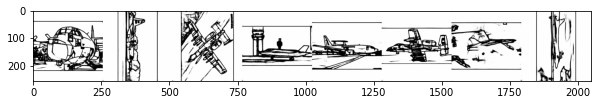

In [11]:
# Data load and transform
transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5)),
                                transforms.Grayscale(num_output_channels=1)
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True
)

# Dataset check
print('train_dataset length :', len(train_dataset))
print('test_dataset length :', len(test_dataset))
print('train RGB Channel size, W, H :', train_dataset[0][0].size())
print('test RGB Channel size, W, H :',test_dataset[0][0].size())
print('train_loader length :', len(train_loader))
print('test_loader length :', len(test_loader))

# MiniBatch image check
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize = (10,7))
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

## 학습 환경 설정

In [12]:
torch.use_deterministic_algorithms(True)
model = resnext50_32x4d(progress = True).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        xm.optimizer_step(optimizer, barrier=True)
        optimizer.step()

from sklearn.metrics import f1_score
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    #f1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            # 작동시키려면 CPU에 넣어야 함
            # f1 += f1_score(target.numpy(), pred.numpy(), average='macro')

            target_ = target
            pred_ = pred.squeeze()

    print('target: ', target_)
    print('pred: ', pred_)
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    #f1 /= len(test_loader.dataset)
    
    return test_loss, test_accuracy#, f1

import gc
import time

gc.collect()
torch.cuda.empty_cache()

## 학습 및 예측

In [14]:
for epoch in range(1, EPOCHS + 1):
    
    start = time.time()

    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    scheduler.step()

    processing_time = (time.time()- start) / 60

    print('[{}], Time: {:.4f}min, Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, processing_time, test_loss, test_accuracy))

target:  tensor([ 8, 10,  2, 11], device='xla:1')
pred:  tensor([5, 5, 5, 4], device='xla:1')
[1], Time: 68.9905min, Test Loss: 1.4947, Accuracy: 9.14%
target:  tensor([ 4, 10,  0,  4], device='xla:1')
pred:  tensor([3, 3, 3, 3], device='xla:1')
[2], Time: 7.6788min, Test Loss: 16.2176, Accuracy: 7.43%
target:  tensor([11,  8, 12,  6], device='xla:1')
pred:  tensor([5, 1, 1, 6], device='xla:1')
[3], Time: 7.3223min, Test Loss: 0.9702, Accuracy: 13.86%
target:  tensor([12, 10, 13,  0], device='xla:1')
pred:  tensor([1, 6, 6, 6], device='xla:1')
[4], Time: 7.3199min, Test Loss: 1.0569, Accuracy: 10.00%


KeyboardInterrupt: ignored

## 신경망 검사

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

## 가중치, 파라미터 확인

In [ ]:
print("Model's state dict:")
for param_tensor in model.state_dict():
  print(param_tensor, '\t', model.state_dict()[param_tensor].size())

## 모델 저장

In [ ]:
# save model
import torch.onnx as onnx
import torchvision.models as models

PATH = '/content/drive/Shareddrives/aircraft/[TPU]model_v0.12.pth'
torch.save(model, PATH)

In [ ]:
model = torch.load(PATH)
print(model)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    
    start = time.time()

    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy, f1 = evaluate(model, test_loader)

    scheduler.step()

    processing_time = (time.time()- start) / 60

    print('[{}], Time: {:.4f}min, Test Loss: {:.4f}, F1-Score: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, processing_time, test_loss, f1, test_accuracy))

In [ ]:
import math
import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 16, 3, stride=1) # in channels, out_channels, kernel_size, stride
        # activation ReLU
        pool1 = nn.MaxPool2d(7) # 6@12*12
        conv2 = nn.Conv2d(16, 16, 3, stride=2) # in channels, out_channels, kernel_size, stride
        # activation ReLU
        pool2 = nn.MaxPool2d(9) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(144, 36)
        # activation ReLU
        fc2 = nn.Linear(36, 8)
        # activation ReLU
        fc3 = nn.Linear(8, 2)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [ ]:
model2 = CNNClassifier()

In [ ]:
learning_rate = 0.01
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# create figure for plotting
row_num = 2
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
train_loss_list = []
test_loss_list = []
criterion = nn.CrossEntropyLoss()
num_batches = len(train_loader)
for epoch in range(EPOCHS):
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model2(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # train_loss summary
        train_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 10 == 0: # every 10 or 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                test_loss = 0.0
                for j, test in enumerate(test_loader):
                    test_x, test_label = test
                    if use_cuda:
                        test_x = test_x.cuda()
                        test_label = test_label.cuda()
                    test_output = model2(test_x)
                    t_loss = criterion(test_output, test_label)
                    test_loss += t_loss

            # draw last test dataset
            for k in range(row_num*col_num):
                ii = k//col_num
                jj = k%col_num
                ax[ii,jj].cla() # clear the current axis
                ax[ii,jj].imshow((test_x[k,:].data.cpu().numpy().reshape(2**9, 2**9)), cmap='Greys')
            
            display.clear_output(wait=True)
            display.display(plt.gcf()) # get a reference to a current figure
                
            print("test label: {}".format(test_label[:row_num*col_num]))
            print("prediction: {}".format(test_output.argmax(dim=1)[:row_num*col_num]))
            del test_output
            del t_loss
            
            print("epoch: {}/{} | step: {}/{} | train loss: {:.4f} | test loss: {:.4f}".format(
                epoch+1, EPOCHS, i+1, num_batches, train_loss / len(train_loader), test_loss / len(test_loader)
            ))            
            
            train_loss_list.append(train_loss/100)
            test_loss_list.append(test_loss/len(test_loader))
            train_loss = 0.0

    test_loss, test_accuracy, f1 = evaluate(model2, test_loader)

    print('[{}] Test Loss: {:.4f}, F1-Score: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, f1, test_accuracy))
    